**Tarea en Clase**

Investigar sobre algún otro algoritmo no supervisado que pueda usarse en tu código. Da un panorama sobre el modelo matemático que emplea y explica por qué conviene aplicarlo a tus datos. Algunos modelos que no se vieron en clase son Affinity Propagation, BIRCH, DBSCAN, Mean Shift, Nearest Neighbors, OPTICS, Spectral Clustering, TSNE, entre otros.

In [19]:
# Leer dataframe con datos
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('datos.csv')

df = df.drop(columns=['R. Comb. (km/l)', 'R. Ajust. (km/l)', 
                     'Calificación Gas Ef. Inv.',
                     'Versión', 'Comb.', 'NOx (g/1000km)'], axis=1)

df_proc = pd.read_csv('datos_proc2.csv')
df_proc = df_proc.drop(columns=['R. Comb. (km/l)', 'R. Ajust. (km/l)', 
                     'Calificación Gas Ef. Inv.',
                     'Versión_Mean_Encoded', 'Comb._Mean_Encoded', 'NOx (g/1000km)'], axis=1)

In [20]:
df.columns

Index(['Marca', 'Submarca', 'Modelo', 'Trans.', 'Cilindros', 'Potencia (HP)',
       'Tamaño (L)', 'Categoría', 'R. Ciudad (km/l)', 'R. Carr. (km/l)',
       'CO2(g/km)', 'Hibrido'],
      dtype='object')

In [21]:
df_proc.columns

Index(['Modelo', 'Cilindros', 'Potencia (HP)', 'Tamaño (L)',
       'R. Ciudad (km/l)', 'R. Carr. (km/l)', 'CO2(g/km)', 'Hibrido',
       'Marca_Mean_Encoded', 'Submarca_Mean_Encoded', 'Trans._Mean_Encoded',
       'Categoría_Mean_Encoded'],
      dtype='object')

*Se procederá a intentar agrupar Submarca ya que cuenta con 544 categorías y esta variable tiene una alta correlación con la variable respuesta*


In [30]:
df_proc[['CO2(g/km)', 'Submarca_Mean_Encoded']].corr()

,CO2(g/km),Submarca_Mean_Encoded
CO2(g/km),1.000000,0.915017
Submarca_Mean_Encoded,0.915017,1.000000


In [32]:
len(df['Submarca'].unique())

544

*El algoritmo no supervisado que se empleará es Mean Shift Clustering*

*Mean Shift es un algoritmo de agrupación usado para resaltar áreas densas en un conjunto de datosy asignar factores a sus respectivos grupos. Es una técnica de agrupación no paramétrica basada en densidad. Este algoritmo descubre agrupaciones basado totalmente en la densidad de las observaciones dentro del área de la función.*

*Vale la pena intentar usar este algoritmo para descubrir posibles agrupaciones de Submarca con CO2, al haber vehículos de submarcas distintas que pudieran estar relacionados por similitudes en emisiones de CO2.*


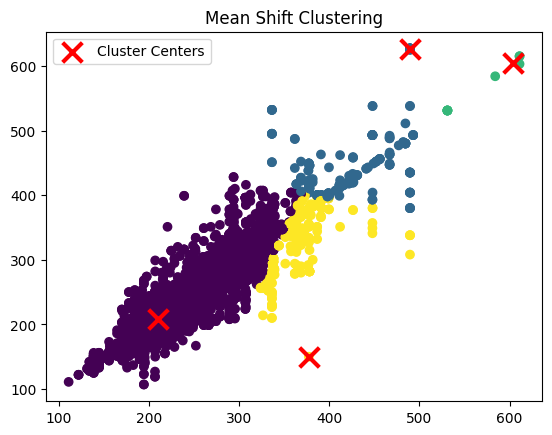

In [39]:
from sklearn.cluster import MeanShift
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Create synthetic data
X = np.array(df_proc[['Submarca_Mean_Encoded', 'CO2(g/km)']])


# Apply Mean Shift clustering
mean_shift = MeanShift()
mean_shift.fit(X)

# Visualize the results
plt.scatter(X[:, 0], X[:, 1], c=mean_shift.labels_, cmap='viridis', marker='o')
plt.scatter(mean_shift.cluster_centers_[:, 0], mean_shift.cluster_centers_[:, 1], 
			c='red', marker='x', s=200, linewidths=3, label='Cluster Centers')
plt.title('Mean Shift Clustering')
plt.legend()
plt.show()


**Tarea**

- Aplicar al menos un algoritmo no supervisado a tus datos para encontrar estructuras subyacentes

- Elegir alguna métrica para determinar número de grupos, usarla y discutirla

- Busca alguna revista científica que publique trabajos relacionados con el tuyo

- Crea artículo mediante Latex con base en los lineamientos de la revista elegida y redacta ahí tus resultados, discusiones y bibliografía

- Sube el código de tu tarea, los archivos de Latex y el PDF del artículo en tu repositorio, claramente diferenciados

In [40]:
scaler = MinMaxScaler()

df_sel_x = df_proc[['Submarca_Mean_Encoded', 'CO2(g/km)']]
scaled = scaler.fit_transform(df_sel_x)

df_scaled = pd.DataFrame(scaled, columns = df_sel_x.columns)
df_scaled

,Submarca_Mean_Encoded,CO2(g/km)
0,0.166818,0.000000
1,0.166818,0.000000
2,0.166818,0.030769
3,0.166818,0.030769
4,0.166818,0.053846
...,...,...
4596,0.534174,0.651923
4597,0.534174,0.651923
4598,0.742000,0.721154
4599,0.742000,0.721154


In [42]:
from sklearn.cluster import KMeans

inertia = []
for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters).fit(df_scaled)
    inertia.append(kmeans.inertia_ / n_clusters)

In [43]:
df_inertias = pd.DataFrame({'n_clusters': range(2, 15), 'inertia': inertia})
df_inertias


,n_clusters,inertia
0,2,35.291214
1,3,13.206095
2,4,6.709023
3,5,4.268596
4,6,2.902158
5,7,2.166659
6,8,1.671700
7,9,1.349996
8,10,1.106981
9,11,0.959145


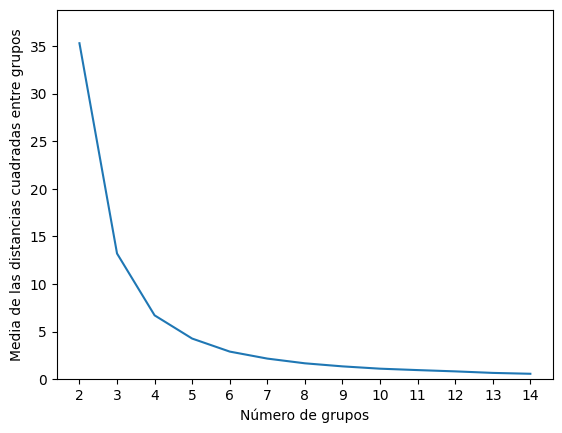

In [44]:
plt.figure()
plt.plot(df_inertias.n_clusters, df_inertias.inertia)
plt.xlabel('Número de grupos')
plt.ylabel('Media de las distancias cuadradas entre grupos')
plt.ylim((0, 1.1 * df_inertias.inertia.max()))
plt.xticks(range(2, 15))
plt.show()

In [45]:
from numpy import ones,vstack
from numpy.linalg import lstsq
points = [
    (df_inertias.iloc[0, :].n_clusters, df_inertias.iloc[0, :].inertia),
    (df_inertias.iloc[-1, :].n_clusters, df_inertias.iloc[-1, :].inertia)
]
x_coords, y_coords = zip(*points)
A = vstack([x_coords, ones(len(x_coords))]).T
m, b = lstsq(A, y_coords, rcond=None)[0]

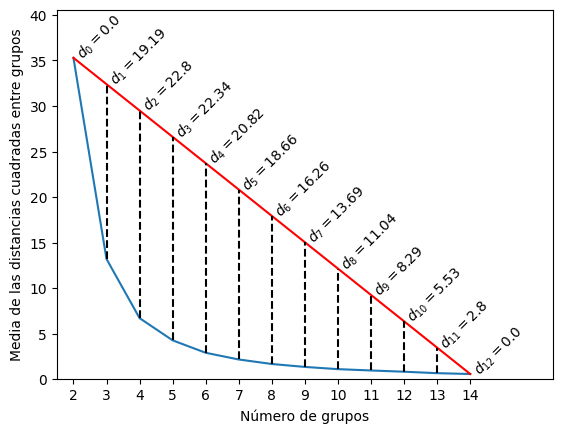

In [46]:
plt.figure()
plt.plot(df_inertias.n_clusters, df_inertias.inertia)
plt.plot(df_inertias.iloc[[0, -1], :].n_clusters, df_inertias.iloc[[0, -1], :].inertia, c='r')
for i, r in df_inertias.iterrows():
    d = '$d_{' + str(i) + '}' + f' = {abs(round(r.inertia - (m * r.n_clusters + b), 2)):,}$'
    plt.annotate(d, xytext=(r.n_clusters, m * r.n_clusters + b), xy=(r.n_clusters, m * r.n_clusters + b), rotation = 45)
    plt.plot([r.n_clusters, r.n_clusters], [r.inertia, m * r.n_clusters + b], '--k')
plt.xlabel('Número de grupos')
plt.ylabel('Media de las distancias cuadradas entre grupos')
plt.xlim((1.5, 16.5))
plt.ylim((0, 1.15 * df_inertias.inertia.max()))
plt.xticks(range(2, 15))
plt.show()

*La mayor distancia se obtiene con k=4 por el método del codo*

In [47]:
kmeans = KMeans(n_clusters=4, n_init = 'auto').fit(df_scaled)

In [48]:
df_centroids_freq = pd.DataFrame(np.unique(kmeans.labels_, return_counts = True)).T
df_centroids_freq.columns = ['ck', 'nk']
df_centroids_freq

,ck,nk
0,0,1760
1,1,306
2,2,1046
3,3,1489


In [49]:
df_centers = pd.DataFrame(kmeans.cluster_centers_, columns = ['x', 'y'])
df_centers

,x,y
0,0.163520,0.158116
1,0.612896,0.626611
2,0.412881,0.417079
3,0.290422,0.280120


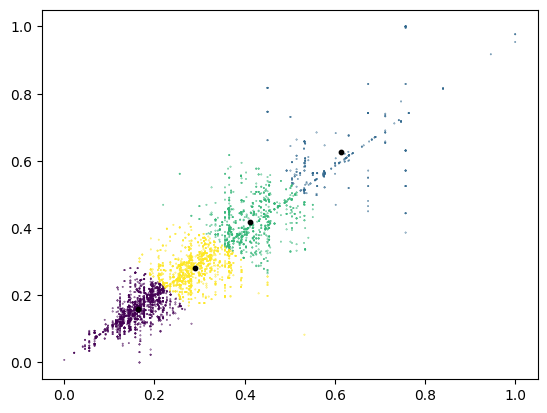

In [51]:
plt.figure()
plt.scatter(
    df_scaled['Submarca_Mean_Encoded'], 
    df_scaled['CO2(g/km)'], 
    s = 0.1, # tamaño de los marcadores
    c = kmeans.labels_
)
plt.scatter(df_centers.x, df_centers.y, s=10, c='k')
plt.show()

Se enocntró el siguiente artículo relacionado a mi proyecto en la revista SciELO.

Elizondo, Alejandra, & Hernández Amezcua, Thalia. (2018). Regulación de las emisiones de CO2 para vehículos ligeros en México. Gestión y política pública, 27(2), 571-594. Recuperado en 21 de julio de 2024, de http://www.scielo.org.mx/scielo.php?script=sci_arttext&pid=S1405-10792018000200571&lng=es&tlng=es.

In [ ]:
# Matriz de correlaciones
import seaborn as sns
import matplotlib.pyplot as plt

matrix = df_proc.corr().round(1)
sns.heatmap(matrix, annot=True)
plt.show()